**Libraries Import**

In [ ]:
!pip install prophet -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

**Import Dataset**

In [ ]:
data = pd.read_csv('/content/sample_data/absher v4.csv')

**Explority Data Analysis (EDA)**

In [ ]:
data.head()

,ds,Date,Time,Num_Appointments,y,Center_ID,CID,Peak_Hour_Flag,Service_Type
0,2024-04-23 05:00:00,2024-04-23,05:00:00,25,25,Center_3,Center_3,No,تجديد
1,2019-09-11 11:00:00,2019-09-11,11:00:00,43,43,Center_2,Center_2,Yes,تعديل بيانات
2,2018-07-30 19:00:00,2018-07-30,19:00:00,23,23,Center_4,Center_4,No,تعديل بيانات
3,2020-11-05 10:00:00,2020-11-05,10:00:00,28,28,Center_4,Center_4,Yes,إصدار جديد
4,2020-04-14 04:00:00,2020-04-14,04:00:00,26,26,Center_1,Center_1,No,إصدار جديد


/tmp/ipython-input-3246659898.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heat_df = data.pivot_table(index='Day', columns='Hour', values='Num_Appointments', aggfunc='mean')


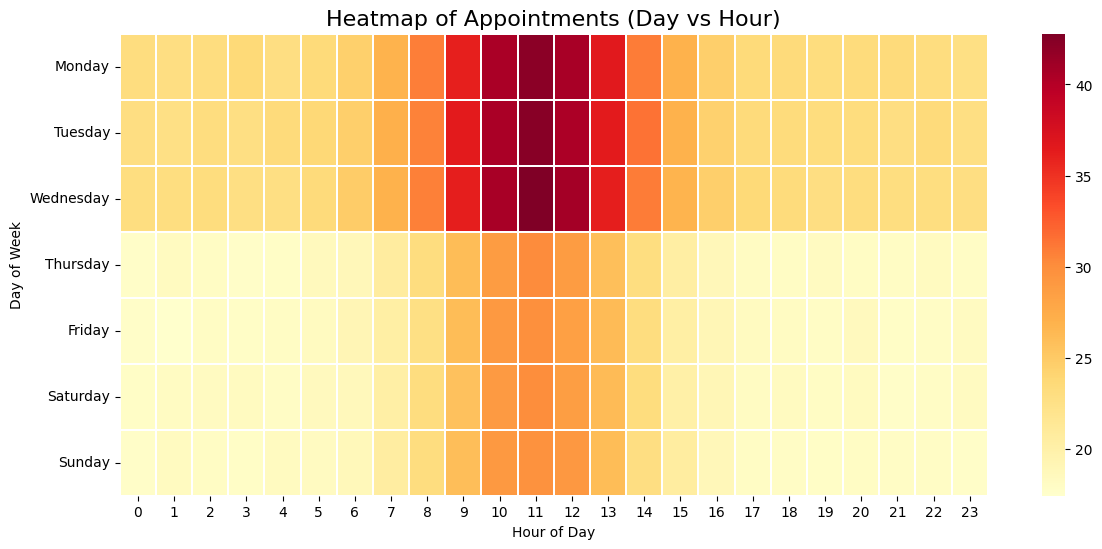

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

data['Hour'] = pd.to_datetime(data['Time'], format="%H:%M:%S").dt.hour
data['Day'] = pd.to_datetime(data['Date']).dt.day_name()

day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
data['Day'] = pd.Categorical(data['Day'], categories=day_order, ordered=True)

heat_df = data.pivot_table(index='Day', columns='Hour', values='Num_Appointments', aggfunc='mean')

plt.figure(figsize=(14,6))
sns.heatmap(heat_df, cmap='YlOrRd', linewidths=.3)
plt.title("Heatmap of Appointments (Day vs Hour)", fontsize=16)
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()


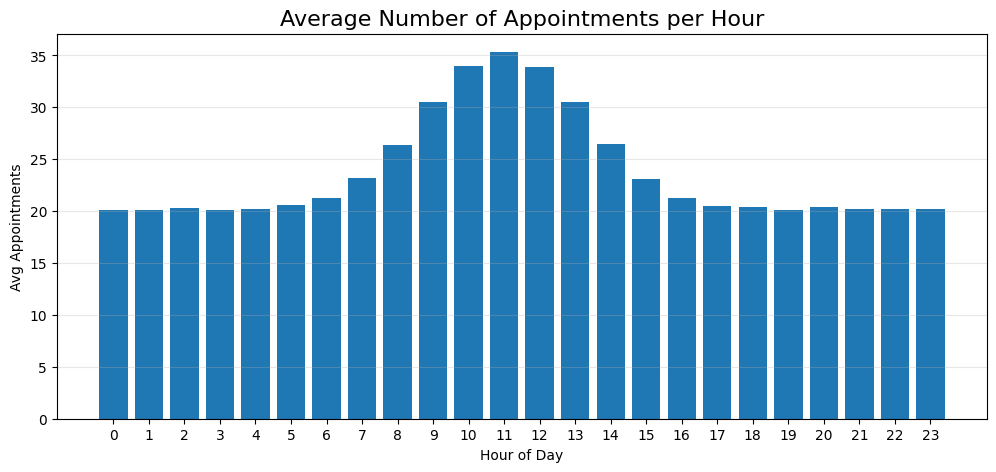

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

data['Hour'] = pd.to_datetime(data['Time'], format="%H:%M:%S").dt.hour

hourly_counts = data.groupby('Hour')['Num_Appointments'].mean()

plt.figure(figsize=(12,5))
plt.bar(hourly_counts.index, hourly_counts.values)
plt.title("Average Number of Appointments per Hour", fontsize=16)
plt.xlabel("Hour of Day")
plt.ylabel("Avg Appointments")
plt.xticks(range(0,24))
plt.grid(axis='y', alpha=0.3)
plt.show()

**Data Preprocessing - Outliers Removing and Fetures Extraction**

In [ ]:
import numpy as np
import pandas as pd

data['ds'] = pd.to_datetime(data['Date'] + " " + data['Time'])
data['y'] = data['Num_Appointments']
data['CID'] = data['Center_ID']

df = data[['ds','y','CID','Peak_Hour_Flag','Service_Type']].sort_values('ds').copy()


def impute_outliers_iqr(df_group, column='y'):

    Q1 = df_group[column].quantile(0.25)
    Q3 = df_group[column].quantile(0.75)


    IQR = Q3 - Q1


    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR


    median_val = df_group[(df_group[column] >= lower_bound) & (df_group[column] <= upper_bound)][column].median()


    df_group[column] = np.where(
        (df_group[column] < lower_bound) | (df_group[column] > upper_bound),
        median_val,
        df_group[column]
    )
    return df_group
df = df.groupby('CID', group_keys=False).apply(impute_outliers_iqr, column='y')

df['hour']        = df['ds'].dt.hour
df['dayofweek']   = df['ds'].dt.dayofweek
df['day_of_month']= df['ds'].dt.day
df['month']       = df['ds'].dt.month
df['week']        = df['ds'].dt.isocalendar().week.astype(int)

df['is_peak'] = (df['Peak_Hour_Flag'] == 'Yes').astype(int)

df['is_passport'] = df['Service_Type'].str.contains('جواز', na=False).astype(int)

centers = df['CID'].unique()
models = {}
forecasts = {}

print("المراكز:", centers)

المراكز: ['Center_5' 'Center_2' 'Center_3' 'Center_1' 'Center_4']


/tmp/ipython-input-1088701856.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('CID', group_keys=False).apply(impute_outliers_iqr, column='y')


In [ ]:
sa_holidays = pd.DataFrame({
    'holiday': 'sa_holiday',
    'ds': pd.to_datetime([
        '2023-04-21','2023-04-22','2023-04-23',
        '2023-06-27','2023-06-28','2023-06-29',
        '2023-09-23',
        '2024-04-10','2024-04-11','2024-04-12',
        '2024-06-16','2024-06-17','2024-06-18',
        '2024-09-23',
        '2025-03-31','2025-04-01','2025-04-02',
        '2025-06-06','2025-06-07','2025-06-08',
        '2025-09-23',
    ])
})

**Prophet Model**

In [ ]:
from prophet import Prophet

for center in centers:

    df_center = df[df['CID'] == center][[
        'ds', 'y', 'hour', 'dayofweek',
        'day_of_month', 'month', 'week',
        'is_peak', 'is_passport'
    ]].copy()




    model = Prophet(
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=5,
        seasonality_prior_scale=20,
        holidays=sa_holidays
    )

   #add  yearly seasonality
    model.add_seasonality(name='daily', period=24, fourier_order=25)
    model.add_seasonality(name='weekly2', period=7, fourier_order=30)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=15)
    model.add_seasonality(name='yearly_custom', period=365.25, fourier_order=20)

    model.add_regressor('hour')
    model.add_regressor('dayofweek')
    model.add_regressor('day_of_month')
    model.add_regressor('month')
    model.add_regressor('week')
    model.add_regressor('is_peak')
    model.add_regressor('is_passport')

    print(f"Training: {center}")
    model.fit(df_center)

    models[center] = model

print("تم تدريب جميع المراكز")

Training: Center_5
Training: Center_2
Training: Center_3
Training: Center_1
Training: Center_4
تم تدريب جميع المراكز


**Model Training**

In [ ]:
future_hours = 24 * 7   #  one week

for center in centers:
    model = models[center]

    future = model.make_future_dataframe(periods=future_hours, freq='H')


    future['hour'] = future['ds'].dt.hour
    future['dayofweek'] = future['ds'].dt.dayofweek
    future['day_of_month'] = future['ds'].dt.day
    future['month'] = future['ds'].dt.month
    future['week'] = future['ds'].dt.isocalendar().week.astype(int)


    future['is_peak'] = future['hour'].isin([9, 10, 11, 12, 13]).astype(int)


    future['is_passport'] = 0


    forecast = model.predict(future)

    forecasts[center] = forecast

print("تم إنشاء التوقعات لجميع المراكز")

/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


تم إنشاء التوقعات لجميع المراكز


Predict the all Best Centers, Dates, and Times

In [ ]:
work_hours = list(range(8, 16))
best_times = {}


last_date = df['ds'].max()

for center in centers:

    forecast = forecasts[center]


    future_only = forecast[
        (forecast['ds'] > last_date) &
        (forecast['ds'].dt.hour.isin(work_hours))
    ].copy()


    if not future_only.empty:

        best_row = future_only.loc[future_only['yhat'].idxmin()]
        best_times[center] = best_row['ds']
    else:

        print(f"لا توجد بيانات مستقبلية ضمن ساعات العمل للمركز {center}")

print(best_times)

{'Center_5': Timestamp('2026-01-02 15:00:00'), 'Center_2': Timestamp('2026-01-04 15:00:00'), 'Center_3': Timestamp('2026-01-03 15:00:00'), 'Center_1': Timestamp('2026-01-03 15:00:00'), 'Center_4': Timestamp('2026-01-03 15:00:00')}


**Predict the Best Center, Date, and Time (only one center)**

In [ ]:
best_center = None
best_time = None
best_value = float('inf')

for center, time in best_times.items():
    yhat_value_log = forecasts[center].loc[
        forecasts[center]['ds'] == time, 'yhat'
    ].values[0]

    yhat_value = np.expm1(yhat_value_log)

    if yhat_value < best_value:
        best_value = yhat_value
        best_center = center
        best_time = time

print(" أقل مركز ازدحام:", best_center)
print(" أفضل موعد:", best_time)

 أقل مركز ازدحام: Center_4
 أفضل موعد: 2026-01-03 15:00:00


**Model Performence Evaluation**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

errors = {}

for center in centers:
    df_center = df[df['CID'] == center][['ds','y']].copy()
    forecast = forecasts[center]

    merged = df_center.merge(
        forecast[['ds','yhat']],
        on='ds',
        how='inner'
    )

    y_true = merged['y'].values


    y_pred = merged['yhat'].values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    errors[center] = {'MAE': mae, 'RMSE': rmse}

    print(f"Center {center}: MAE={mae:.2f}, RMSE={rmse:.2f}")

errors

Center Center_5: MAE=2.76, RMSE=3.52
Center Center_2: MAE=2.79, RMSE=3.55
Center Center_3: MAE=2.81, RMSE=3.57
Center Center_1: MAE=2.79, RMSE=3.55
Center Center_4: MAE=2.77, RMSE=3.51


{'Center_5': {'MAE': 2.7640769336778193,
  'RMSE': np.float64(3.5220697415550206)},
 'Center_2': {'MAE': 2.7862131859999804,
  'RMSE': np.float64(3.546937092560441)},
 'Center_3': {'MAE': 2.8116010753325185,
  'RMSE': np.float64(3.574869034485276)},
 'Center_1': {'MAE': 2.7932295933432587,
  'RMSE': np.float64(3.5547580667621594)},
 'Center_4': {'MAE': 2.773011654319134, 'RMSE': np.float64(3.512640565101727)}}

**Plot the Actual vs Forecast for the predicted best center**

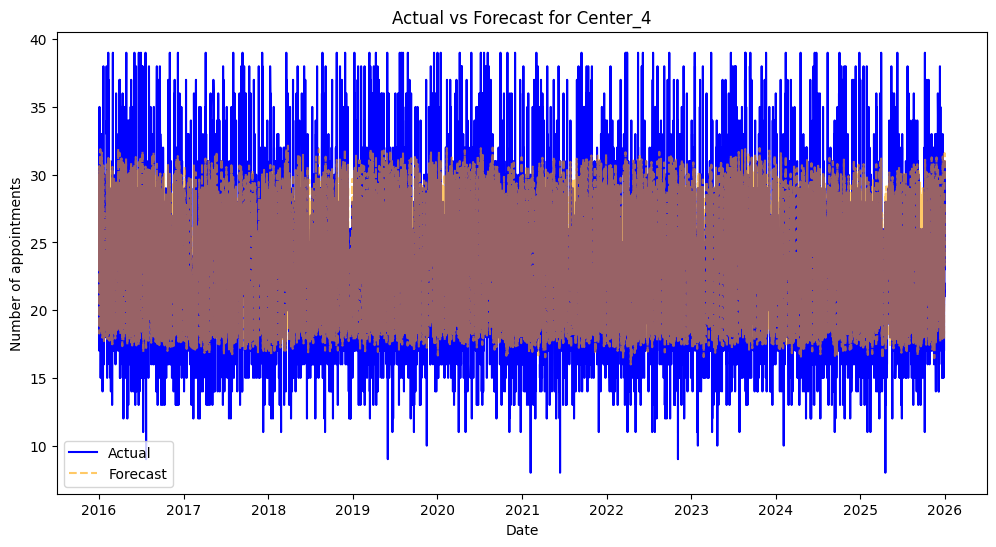

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(merged['ds'], merged['y'], label='Actual', color='blue')
plt.plot(merged['ds'], merged['yhat'], label='Forecast', color='orange', alpha=0.6, linestyle='--')
plt.title(f'Actual vs Forecast for {best_center}')
plt.xlabel('Date')
plt.ylabel('Number of appointments')
plt.legend()
plt.show()

**Show model performance in a table**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

y_true = merged['y']
y_pred = merged['yhat']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

metrics_data = [['MAE', f'{mae:.2f}'],
        ['RMSE', f'{rmse:.2f}']]

fig, ax = plt.subplots(figsize=(4,2))
ax.axis('off')
table = ax.table(cellText=metrics_data, colLabels=['Metric', 'Value'], loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1,2)
plt.title(f'Model Accuracy for {best_center}', fontsize=14)
plt.show()